<a href="https://colab.research.google.com/github/thhtruc/NeuralNetwork/blob/main/CIFAR_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


In [2]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

num_workers = 0
batch_size = 20
valid_size = 0.2


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

train_data = datasets.CIFAR10('train_data', train=True,
                              download=True, transform=transform)
test_data = datasets.CIFAR10('test_data', train=False,
                             download=True, transform=transform)


num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)


train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting train_data/cifar-10-python.tar.gz to train_data


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting test_data/cifar-10-python.tar.gz to test_data


In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0))) 

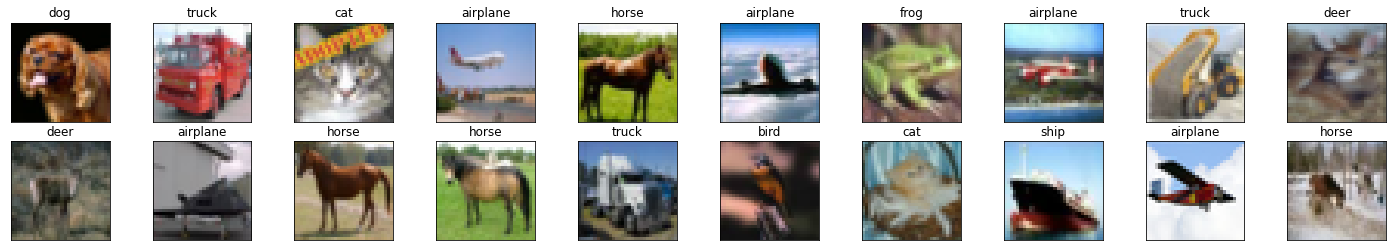

In [4]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [5]:
print(images.shape)

(20, 3, 32, 32)


torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)

In [6]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 4 * 4, 500)
        self.fc2 = nn.Linear(500, 10)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) #16x16x16
        x = self.pool(F.relu(self.conv2(x))) #8x8x32
        x = self.pool(F.relu(self.conv3(x))) #4x4x64
        x = x.view(-1, 64 * 4 * 4)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
model = CNN()
print(model)

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [7]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [8]:
import time


tic = time.time()
n_epochs = 10
train_losses, valid_losses = [], []
for epoch in range(1, n_epochs+1):

    train_loss = 0.0
    valid_loss = 0.0

    # train the model
    model.train()
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
         
    # validate the model    
    model.eval()
    for data, target in valid_loader:
        output = model(data)
        loss = criterion(output, target)
        valid_loss += loss.item()
    train_loss = train_loss/len(train_loader.sampler)
    train_losses.append(train_loss)
    valid_loss = valid_loss/len(valid_loader.sampler)
    valid_losses.append(valid_loss)
        
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
toc = time.time()

print("Time:", 1000000*(toc-tic), "s")

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 1 	Training Loss: 0.107334 	Validation Loss: 0.096257
Epoch: 2 	Training Loss: 0.088379 	Validation Loss: 0.076133
Epoch: 3 	Training Loss: 0.075456 	Validation Loss: 0.072471
Epoch: 4 	Training Loss: 0.069210 	Validation Loss: 0.065144
Epoch: 5 	Training Loss: 0.064374 	Validation Loss: 0.059700
Epoch: 6 	Training Loss: 0.060139 	Validation Loss: 0.055989
Epoch: 7 	Training Loss: 0.056614 	Validation Loss: 0.052537
Epoch: 8 	Training Loss: 0.053915 	Validation Loss: 0.050737
Epoch: 9 	Training Loss: 0.051038 	Validation Loss: 0.047920
Epoch: 10 	Training Loss: 0.048758 	Validation Loss: 0.046188
Time: 537682691.8125153 s


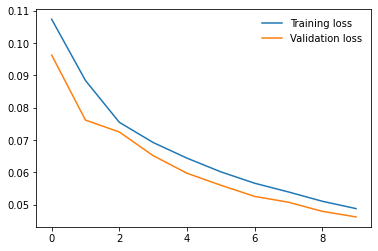

In [9]:
plt.plot(train_losses, label="Training loss")
plt.plot(valid_losses, label='Validation loss')
plt.legend(frameon=False)

In [10]:
test_loss = 0.0
class_correct = list(0.0 for i in range(10))
class_total = list(0.0 for i in range(10))

model.eval()
for data, target in test_loader:
    output = model(data)
    loss = criterion(output, target)
    test_loss += loss.item()
    _, pred = torch.max(output, 1)
    # print(target.data.view_as(pred))
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.046498

Test Accuracy of airplane: 72% (728/1000)
Test Accuracy of automobile: 75% (753/1000)
Test Accuracy of  bird: 50% (501/1000)
Test Accuracy of   cat: 49% (492/1000)
Test Accuracy of  deer: 69% (699/1000)
Test Accuracy of   dog: 48% (483/1000)
Test Accuracy of  frog: 76% (762/1000)
Test Accuracy of horse: 72% (723/1000)
Test Accuracy of  ship: 86% (868/1000)
Test Accuracy of truck: 73% (730/1000)

Test Accuracy (Overall): 67% (6739/10000)
